# <span>Capstone Part 03</span>
*Text analytics and Modelling on Aviation Accident Analysis*
## Submitted by - Roshan Lulu



****
> ![Narrative Analytics](./assets/text_analytics.jpg)

## Introduction
- In this Notebook I will be analyzing the accident summary in the dataset.
- Along with analysing the patterns in accidents based on different features, it would be interesting to classify the incidents based on the narrative.

## A. Import Dataset
- The raw dataset was from aviation.net was cleaned during the data munging and exploratory data analysis phase. 
- I will be reading in the cleaned version of the dataset here to have a look at the **Narrative** feature

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale=1.5)

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
path = './dataset/01_aviation_cleaned.csv'

In [3]:
data = pd.read_csv(path)

In [4]:
data.head(2)

,Engines,Narrative,FlightNumber,InvestigatingAgency,Status,Nature,AirplaneDamage,Phase,DestinationAirport,Date,Time,DepartureAirport,Operator,DurationOfInvestigation,AirplaneFate,FirstFlight,Nature_Code,Type_Code,Engine_Type,Engine_count,Crew_Fatal,Crew_Occ,Total_Fatal,Total_Occ,Psngr_Fatal,Psngr_Occ,GndFatal,Coll_Fatal,Crash_Elev_m,Day,Month,Year,Dep_Airport_1,Dest_Airport_1,SubLocation,Country,Age,Location_latlon
0,NaN,The Peruvian Metro 23 was apparently involved ...,0,NaN,NaN,Military,Damaged beyond repair,Unknown (UNK),?,0,NaN,?,Fuerza Aérea del Peru - FAP,NaN,NaN,1992,Military,Swearingen,NaN,NaN,0,0,0,0,0,0,0,0,0,xx,xxx,0,?,?,unknown,Peru,0,"(-9.189967, -75.015152)"
1,1 BMW VI,Reportedly damaged beyond repair.,1,NaN,NaN,Cargo,Damaged beyond repair,Unknown (UNK),?,0,NaN,?,Deutsche Lufthansa,NaN,NaN,1925,Cargo,Junkers,BMW,1.0,0,0,0,0,0,0,0,0,0,xx,xxx,1935,?,?,at an unknown location,Germany,10,"(51.165691, 10.451526)"


## Natural Language Processing

## B. Text Pre-Processing - Noise Removal

** Text is one of the most unstructured forms of data and Noise removal is a very important step before any data can be analysed. So is the case for text.**

**Noise is information that either corrupts your data or is not useful. Below are some of the common forms of noise in text and that I will be employing going ahead:**

**1. Stop words are the most commonly used words in a language. i.e the words that do not convey meaniful information if on its own. eg: The, A, An, Is, for etc**


**2. Punctuations also do not convey any information from an analytics point of view. Hence, it can also be considered as Noise.**

#### <span style='color:#990000'>Noise(text) = Stopwords(text language) + Punctuation(text)</span>

In [5]:
# Import library 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models, matutils
from collections import defaultdict
import string
from nltk import word_tokenize 
import pycountry

**This is a live stop word listt that I will be iteratively updating. It is a challenge when dealing with unstructured text.**

My list will consist of:
- English stop words
- Country name stop words
- Common aviation terms like airplane, airline etc

In [6]:
# Creating stop words database for all the numbers
stop = stopwords.words('english')
stop += ['00', '000', '01', '02', '03', '04', '04r', '05', '050', '05l', '05r', '06', '06r', '07', '08', '080', '09', '09r', '10', '100', '1000', '10000', '102', '103', '104', '1049', '105', '106', '107', '108', '109', '10deg', '10l', '11', '110', '1100', '111', '111f', '112', '113', '114', '115', '116', '117', '118', '118a', '119', '11f', '11s', '12', '120', '1200', '12000', '121', '361', '376','122', '123', '124', '124c', '125', '128', '129', '12bk', '13', '130', '1300', '130b', '130e', '130h', '130j', '131', '133', '134', '135', '135a', '139', '13l', '14', '140', '1400', '141', '1420', '145', '14500', '146', '148', '15', '150', '1500', '153', '154', '157', '158', '159', '15deg', '16', '160', '1600', '163', '165', '166', '168', '16r', '17', '170', '1700', '172', '175', '1750', '17l', '18', '180', '1800', '180deg', '185', '188', '19', '190', '1900', '1900c', '1900d', '191', '1936', '1938', '1940', '1941', '1942', '1943', '1944', '1945', '1948', '1949', '1950', '1951', '1953', '1954', '1955', '1957', '1963', '1964', '1966', '1968', '1969', '1972', '1973', '1974', '1978', '1979', '1980', '1981', '1982', '1983', '1985', '1986', '1988', '1990', '1991', '1992', '1993', '1994', '1997', '1998', '1999', '19r', '1a', '1a10', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '200c', '201', '2011', '2013', '2015', '202', '203', '2050', '207', '208', '208b', '20deg', '21', '210', '211', '212', '215', '22', '220', '2200', '222', '225', '227', '228', '22l', '23', '230', '2300', '232', '235', '24', '240', '2400', '241', '242', '24b', '24l', '24r', '24rv', '25', '250', '2500', '25l', '26', '260', '265', '266', '26b', '26l', '27', '270', '2700', '27l', '27r', '28', '280', '2800', '285', '28l', '28r', '29', '290', '29l', '2a', '2r', '2t', '30', '300', '3000', '304', '306', '30deg', '31', '310', '31242', '31243', '314', '315', '31l', '31r', '32', '320', '3200', '320o', '322', '325', '328', '32l', '32r', '33', '330', '3300', '330o', '336', '338', '33l', '34', '340', '340b', '340o', '345', '35', '350', '3500', '350o', '35a', '35l', '36', '360', '3600', '37', '38', '39', '390', '3a', '3c', '3deg', '3m', '3mge', '3t', '40', '400', '4000', '41', '410', '410uvp', '42', '420', '4200', '43', '430', '436', '44', '440', '45', '450', '4500', '45deg', '46', '46d', '47', '470', '4700', '47a', '47b', '47d', '47s', '48', '49', '50', '500', '5000', '501', '504', '50832', '50deg', '51', '52', '525', '53', '54', '5400', '55', '550', '5500', '56', '57', '58', '580', '59', '5a', '5h', '5n', '5nm', '5y', '60', '600', '6000', '601', '61', '610', '62', '620', '63', '631', '64', '640', '65', '650', '6500', '66', '67', '68', '6a', '6e', '70', '700', '7000', '707', '71', '710', '72', '720', '725', '727', '73', '737', '74', '747', '748', '75', '750', '7500', '756', '757', '76', '767', '767s', '76md', '770', '777', '78', '78505', '7nm', '80', '800', '8000', '801', '81', '811', '812', '82', '8235', '8241', '82a', '83', '84', '85', '850', '8500', '86', '87', '88', '8807', '89', '8q', '8th', '90', '900', '9000', '90deg', '91', '910', '92', '93', '931', '94', '95', '96', '97', '98', '99', '990', '9k', '9n', '9q', 'a100', 'a300', 'a310', 'a319', 'a320', 'a321', 'a330', 'a6m2', 'aa', 'aaa', 'aab', 'aaf', 'ab', 'ababa']
stop += ['08r', '1009', '101', '1011', '104b', '144', '21st', '221', '22285', '231', '23l', '300yds', '301', '3100', '318', '319', '31de', '321', '321b', '324', '3277', '33666', '33r', '380', '3800', '395', '39a', '3mce', '400a', '402q', '40563', '40deg', '415', '42e', '42w', '4300', '451', '460', '701', '702', '712', '730', '740', '75a', '76td', '7700', '775', '780', '78270', '78462', '785', '797', '800xp', '823', '841', '8as', '8r', '901', '919', '920', '926', '980', '9j', '9l', '9m']
stop += ['675','680','6800','6b', '000ft']
stop += ['airport', 'airplane','aircraft', 'approach',
 'crashed','crew','feet','flight','following','main','members','near','one','operated','passenger','passengers','plane','runway','struck','substantial','sustained','three','took','two','boeing','dc','due','beyond',
 'damaged','b200','repair', 'miles', 'km', 'air', 'lines', 'departed', 'abort', 'takeoff', 'landing', 'reported', 'airline', 'captain'
 ]
stop += ['001', '0014', '002', '003', '006', '010', '010º', '0127', '015', '017', '0171', '0173', '0195', '01l', '01r', '020', '020deg', '0218', '022', '024', '0256', '02801', '02r', '030', '030º', '0326', '0328', '040', '040b', '040deg', '044', '045', '0450', '0462', '0463', '049', '04l', '053', '0597', '060', '0602', '060deg', '061', '064', '069', '06l', '070', '0703', '0705', '0719', '072', '0730', '07308', '075deg', '076', '07l', '07r', '0839', '085', '0850', '08l', '090', '0900', '090deg', '092', '094', '0970', '0972', '0981', '09l', '1002', '1006', '1007', '1008', '100912', '100deg', '100e', '100er', '100nm', '100yds', '10100', '1015', '1018', '1020', '10200', '1024', '1025', '1027', '10350', '1036', '1040', '1041k', '104g', '1050', '10500', '1054', '10554', '1058', '1060', '10687', '1069', '1070', '10737', '1074', '1075', '1081', '1086', '10884', '10942', '109770', '10a', '10f', '10nm', '11000', '110c', '110p1', '1114', '1120', '11200', '1121', '1123', '1124', '1124a', '1132', '1140', '11500', '1154', '1159', '11600', '11620', '1169', '1170', '1171', '1173', '117d', '11800', '11900', '1198', '119b', '119c', '119cf', '119f', '119k', '11a', '11deg', '11dme', '1200yds', '120er', '1212', '1215', '121d', '121g', '121k', '121m', '122443', '1229', '1230', '12328', '12364', '123k', '12435', '12467', '124a', '1250', '12500', '1255', '125kts', '126', '1260', '12600', '127', '1276', '1277', '127723', '1279', '1281', '1296', '12a', '12b', '12bp', '12deg', '12l', '12n', '12p', '12th', '12w', '13000', '1300k', '1301', '1307', '130a', '130f', '130kias', '130m', '130p', '130r', '1310', '131582', '131639', '131e', '131f', '132', '1320', '13200', '1322', '1325gal', '1329', '1338', '133b', '133deg', '1340', '13400', '1342', '1347', '134a', '134ak', '13500', '135350', '1355', '135deg', '135j', '135kl', '135lr', '135n', '135r', '135s', '135t', '135v', '136', '1360', '137', '1370', '137e', '138', '13807', '1390', '13e', '13r', '14000', '1400z', '140a', '141b', '142', '143', '1436', '1440', '1449', '144a', '1450', '1455', '1457', '145kts', '145li', '145lr', '145lu', '146deg', '147', '1486', '149', '1490', '1493', '1495', '14970', '149813', '149d', '14b', '14fkm', '14p', '14th', '15000', '1500yds', '1500z', '1502', '1509', '150deg', '150f', '150ft', '150h', '150m', '151', '151890', '152', '15200', '152608', '1533', '1535', '1539', '1541', '1545', '1549', '154a', '154b', '154m', '155', '1550', '155130', '1553', '15585', '155deg', '156', '15652', '15677', '1568', '1570', '15721', '157332', '15800', '158761', '1588', '158930', '159325', '15f', '15l', '15r', '15s', '15th', '15tm', '16000', '1602', '160r', '161', '1610', '16100', '162', '164', '1640', '1645', '16481', '1649a', '16500', '165522', '165525', '1669', '167', '16720', '1687', '1690', '16a', '16b', '16d', '16f', '16l', '16th', '17000', '17010', '1707', '1709', '1716', '171st', '1720', '1721', '1723', '172n', '173', '1730', '1733', '1736', '17388', '174', '1763', '1768', '178', '178deg', '179', '1790', '17c', '17f', '17g', '17r', '17th', '18000', '1801', '181', '1810', '1814', '182', '18255', '1828', '182l', '1833', '1840', '18440', '1850', '1851', '18591', '18598', '186', '1860', '187', '1870', '1880', '1885', '189', '18930l', '18a', '18b', '18d', '18r', '18th', '18v', '19000', '1902', '1908', '1909', '190deg', '1910', '1918', '192', '1920', '1921', '1922p', '1923', '1925', '1929', '193', '1930', '1933', '1934', '1935', '1937', '1939', '194', '1946', '1947', '195', '1952', '1956', '1958', '1959', '1960', '1961', '1962', '1967', '197', '1970', '1971', '1975', '1976', '1977', '198', '1984', '1987', '1989', '1990s', '1995', '1996', '199deg', '19a', '19l', '1b', '1g167', '1h', '1h18', '1hour', '1l', '1r', '20000', '2000ft', '2008', '2009', '200b', '200deg', '200er', '200ft', '200x100', '200yds', '2010', '2012', '2014', '2016', '2025', '204', '204b', '205', '206', '206b', '2086', '209b', '20c', '20f', '20gmt', '20l', '20r', '20th', '2100', '2104', '2110', '212667', '212a', '213', '214', '21504', '216', '2165', '218', '21b', '21l', '21mf', '21r', '21u', '2200m', '220º', '2215', '2219', '221f', '2230', '224', '2250rpm', '226', '227ac', '227b', '227bc', '2280', '2284', '2286', '229', '2295', '22c', '22r', '2300yds', '2303', '2311', '2318', '233', '23310', '23488', '2350', '235m', '236', '2370', '238', '238b', '23f', '23r', '24000', '2400rpm', '2406', '240deg', '2422x', '243', '245', '2450', '246', '2460', '246er', '246tg', '247', '247d', '248', '2487', '24a', '24bi', '24kay', '24ko', '24th', '25000', '2501f', '250deg', '250yds', '250º', '251', '2523', '255', '2560', '258', '25b', '25d', '25deg', '25g', '25nm', '25pd', '25r', '25th', '2600', '2600rpm', '260deg', '261', '2615', '2620', '263', '2638', '26492', '2650', '2652', '26r', '27097', '270deg', '271', '2710', '2720', '2733', '2734', '274', '2740', '2747', '275', '2750', '277', '2771', '2790', '27deg', '27th', '280c', '280º', '2813', '2823', '283er', '284', '2841', '2850', '2850rpm', '286', '287', '2873', '288', '2885', '28d', '28nm', '28p', '28th', '2900', '291', '2925', '295m', '296', '297', '298', '29nm', '29r', '2a8', '2b', '2deg', '2e', '2f', '2h', '2nd', '2nm', '2p', '2sq', '2t5', '2tp', '2u3b', '3002', '300er', '300s', '300º', '302ftu', '303', '3050', '3068', '306m', '307', '3079', '307b', '308', '30862', '30a', '30b', '30cf', '30f', '30l', '30psi', '30r', '30th', '3102', '3108', '310deg', '310º', '311', '311q', '312', '3120', '3130', '3132', '3137', '3150', '317', '3183', '31fi', '3205', '320º', '3232', '3233', '3244lb', '3252', '3260', '3263', '3281', '328jet', '329c', '32a', '32tons', '32z', '330yds', '330º', '331', '3316', '334', '335', '3380', '339', '33a', '33rc', '3400', '34037', '340a', '340er', '340º', '3416', '342', '343', '343rd', '344', '344c', '3476', '34deg', '34l', '34r', '3506', '350º', '352nd', '353', '354', '3540', '355', '357', '3587', '35deg', '35r', '360deg', '3628', '365', '366', '3666', '366er', '3679', '3680', '368lb', '369', '3698', '36a', '36l', '36n', '36r', '370', '3700', '3700rpm', '371', '3720', '375', '377', '378', '379c', '379th', '381er', '3839x', '384th', '385', '38658', '38667', '387', '389', '38th', '3900', '392', '3930', '39323', '39325', '3960', '398', '39939', '39980', '39n', '3b', '3b4c', '3h4', '3k1c', '3l', '3mfe', '3mg4e', '3mlu', '3mte', '3nm', '3rd', '400b', '400bcf', '400yds', '402', '403', '40312', '404', '4042', '405', '406', '4064', '40641', '4069', '407', '408', '40a', '40cm', '40gmt', '40in', '40k', '40nm', '40s2', '40z', '4100', '411', '412f', '413th', '4146', '418', '41834', '419', '4192', '41deg', '41st', '4204', '422', '42444', '425', '4250', '4265', '42a', '42b', '431', '4317', '4340', '435', '4350', '436th', '4374', '439', '43b', '43s', '4400', '441', '44166', '4422', '444', '4458', '44648', '4479', '4525', '4536', '4539', '455', '457', '45g', '4600', '462', '46327', '465', '467', '46807', '46deg', '46e', '46f', '471', '4723', '47302', '47360', '474', '475', '4750', '477', '47deg', '47e', '47j', '47nm', '47p', '47q', '480', '4805', '481', '484', '4860', '4896', '490', '4900', '4904', '491', '4915', '492', '495', '496', '499', '4a', '4c', '4f', '4g', '4h6', '4k', '4l', '4nm', '4y0', '500ft', '500m', '500sq', '500yds', '501sp', '502', '5049', '505', '506', '507', '508', '509', '50c', '50feet', '50psi', '50s', '50th', '510', '5100', '512', '5120', '5160', '518', '520', '52002', '524', '5250', '525c', '527', '529', '52g', '530', '5300', '530yds', '5315', '5323', '5340', '537', '53d', '540', '5401', '5407', '541', '542ct', '543', '545', '5452', '546', '54a', '54b', '550b', '5513', '553', '5539', '557', '558', '55deg', '55kts', '55th', '560', '5600', '560xl', '561', '5615', '5669', '5675', '56g', '56pst', '56th', '570', '5700', '5711', '572', '5733', '57752', '57760', '5800', '580a', '580as', '5811', '583', '585', '588', '589', '590', '5900', '592', '594', '595', '599', '59d', '5b', '5d', '5deg', '5e', '5f', '5g', '5th', '5v', '5x', '5x61', '600f', '600gal', '600r', '600yds', '6013', '6017', '601e', '602', '603', '60314', '603m', '603sq', '604', '6048', '6050', '605r', '6060', '60deg', '6100', '611', '614', '6150', '6163', '6165', '61708', '618', '621', '623', '6240', '625', '6250', '626', '627', '628', '6289', '6291', '62f', '630', '6300', '634', '6343', '635', '6350', '6354', '63f', '6400', '642', '6420', '643', '6448', '64w', '6500ft', '65120', '652', '6526', '654', '655', '65691', '658', '65856', '65nm', '661', '663', '6631', '664', '666', '6700', '670a', '671', '6715', '6745', '676', '67608', '6780', '6800ft', '681', '6865', '687', '6878', '6901', '696', '69620', '6970', '6bf', '6deg', '6in', '6nm', '6th', '70000', '700a', '700b', '70349', '704', '705', '706', '708', '70yds', '7100', '711', '714', '716', '717', '718', '7200', '721', '7218', '724', '726', '72614', '731', '732', '7353', '736', '738', '739', '73960', '7400', '742', '7463', '747sp', '749', '7493', '751', '752', '753', '7533', '75687', '75732', '760', '7613', '7638', '765', '76679', '76685', '76761', '7682', '76825', '76827', '76t', '77', '771', '772', '773', '7743', '77508', '7775', '7800', '7800ft', '7815', '7816', '783', '783cp', '7843', '785d', '7864', '78826', '78849', '79', '790', '793', '7980', '7989', '7b', '7c', '7deg', '7m', '7occupants', '7½', '8000f', '800b', '800ft', '8012', '8015', '8019', '802', '805', '8050', '806', '809', '80c2b2', '80deg', '81000', '813', '8137', '813th', '814', '817', '819', '820', '821', '824', '8276', '82s', '8300', '831', '8315', '832', '835', '8355', '837', '839', '840', '8400', '843', '844', '84738', '84g', '8502', '850xp', '851', '8535', '855', '860', '8600', '861', '8650', '8665', '86a', '86b', '86d', '870', '8700', '8738', '875', '878', '87s', '881', '8810', '88241', '885', '886', '8867', '890', '897', '89d', '8c', '8f600', '8g', '8h4', '8nm', '900c', '9018', '901a', '902', '904', '906', '90nm', '90º', '9100', '911', '914', '916', '918', '9202', '921', '922', '9243', '927', '930', '9300', '933', '9350', '936', '940', '941', '942', '946', '94b', '950', '9500'
         , '953', '95981', '95b', '960', '962633', '9640', '967', '96th', '970', '9700', '975', '9766', '97g', '9800', '983', '984', '9842', '985', '9859', '9877', '9900', '99165', '9925', '9930', '9955', '9975', '99853', '99a', '99c', '9d', '9k38', '9th', '9v', '9w354', 'a1', 'a12', 'a185f', 'a2', 'a23', 'a300b4', 'a31', 'a340', 'a36', 'a4', 'a400m', 'a59', 'a59w', 'a6', 'a65', 'a6m', 'a7', 'aa201', 'aa320', 'aa423', 'aa699', 'aac', 'aam', 'aapo', 'aar', 'aarhus', 'aau']

In [7]:
# Add all countries as stop words
for c in list(pycountry.countries):
    stop.append(c.name.lower())

In [8]:
### Remove punctuations

## C. Text PreProcessing
### Text Normalisation

**Normalisation of data is converting different forms of the same word into a common one. Two of the commonly used forms are :**

** 1. Stemming i.e. stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.**
- I tried using Stemming for my text, but it stripped the word of all its meaning, hence currently I am not using stemming. 


** 2. Lemmatization i.e. an organised and step by step procedure of obtaining the root form of the word, it makes use of vocabulary and word structure and grammar relations.**
- Lemmatization, did not help me much. For now, I am not using these functions. But at a later point I will come back to it if required.

In [9]:
stemmer = PorterStemmer()

In [10]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    print(stems)
    return stems

## D. Feature Extraction
### Count Vectorizer: to get the most commonly used vocabulary

** Count vectorizer is one of the basic techniques when dealing with textual content. It is the process of getting a word count of the text/document. The parameters of a count vectorizer can be modified depending on the problem at hand.**

*As an initial step, I will be analyzing the word count from all the aviation accident summaries*
- There are 14836 distinct words excluding the stop words.

In [11]:
# vectorizer = CountVectorizer(analyzer = "word",tokenizer = None, lowercase=True, strip_accents="unicode",
#                              preprocessor = None,stop_words = stop,max_features = 1000, ngram_range = (1,1)) 

vectorizer = CountVectorizer(analyzer = 'word', stop_words = stop) 
X_narrative = vectorizer.fit_transform(data['Narrative'])

In [12]:
X_narrative.shape

(8172, 14836)

In [13]:
# This is a dictionary of the format {word: wordcount}
vocabulary = vectorizer.vocabulary_
# displaying only a few values 
count = 0
for word in vocabulary:
    if count < 10:
        print (word, vocabulary[word])
    count += 1

peruvian 10022
metro 8168
apparently 688
involved 6376
accident 64
wreck 14578
seen 11716
hangar 5583
lima 7415
september 11773


In [14]:
# The distinct words acan be obtained using the get feature method
distinct_words = vectorizer.get_feature_names()
# displaying a sample from the word list
distinct_words[0:10]

['abalone',
 'abandon',
 'abandoned',
 'abatement',
 'abatova',
 'abbas',
 'abbeville',
 'abdomen',
 'abdrabbu',
 'abdulaziz']

In [15]:
# Converting the distinct words from the model to a dataframe to view the most frequent words
docs = pd.DataFrame(X_narrative.todense(), columns=distinct_words)
docs_df = pd.DataFrame(docs.sum().sort_values(ascending = False)).reset_index()
docs_df_top20 = docs_df[0:20]
docs_df_top20.columns = ['word', 'count']

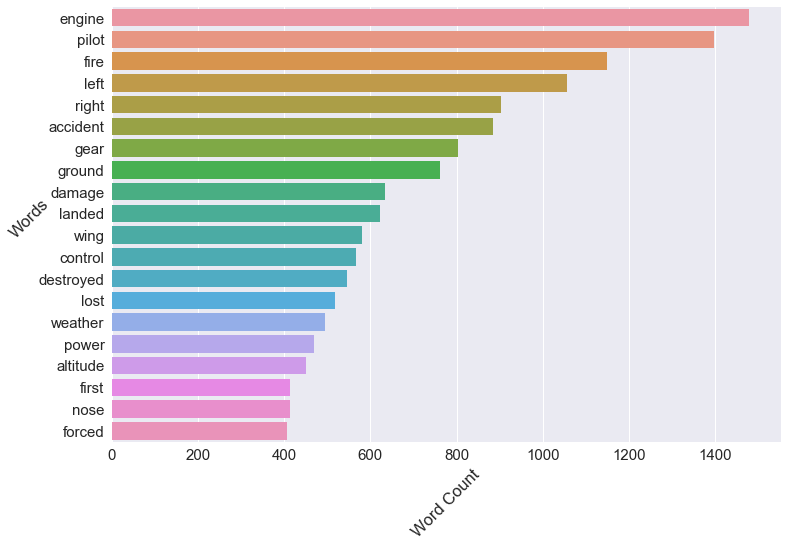

In [16]:
fig = plt.figure(figsize = (12,8))
sns.barplot(y=docs_df_top20['word'], x=docs_df_top20['count'])
plt.xlabel('Word Count', rotation = 45)
plt.ylabel('Words', rotation = 45)
plt.show()
fig.savefig('./gen_plots/wordcount.png')

## E. Unsupervised Topic Modelling using LDA (Latent Dirichlet Allocation)

I am interested to divide the topics based on the cause of accidents. Hence Clustering them based on the description is the next task. There are many approaches for obtaining topics from a text. 
- Latent Dirichlet Allocation is the most popular topic modeling technique and I am planning to try that first.
-  Term Frequency and Inverse Document Frequency and NonNegative Matrix Factorization techniques are the other topic modelling techniques


**Cleaning and Preprocessing**

Cleaning is an important step before any text mining task. Since this has already been done above. we wont be looking at it.

**Preparing Document-Term(DT) Matrix**

All the text documents combined is known as the **corpus**. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the DT matrix.

**Running LDA Model**

Next step is to create an object for LDA model. The dataset does not have enough information to divide it into train and test sets. To begin, I will be using the LDA model to come up with similar words to create topics for the incidents. This can also be seen as feature engineering using the model. I expect to see some interesting results with this model.

In [17]:
from nltk.stem.wordnet import WordNetLemmatizer
import string

exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Clean the summaries
data['Narrative_Clean'] = [clean(doc).split() for doc in data['Narrative']] 

In [18]:
# This is the fastest way to swap a dictionary key / value order.  
# This is the format gensim LDA expects it's vocabulary.
vocab = {v: k for k, v in vocabulary.items()}

In [19]:
# Now, we are going to create the vocabulary of each accident narrative

frequency = defaultdict(int)
for text in data['Narrative_Clean']:
    for token in text:
        frequency[token] += 1

# The map of every word in the summary is formed here
frequency

defaultdict(int,
            {'peruvian': 7,
             'metro': 42,
             'apparently': 47,
             'involved': 38,
             'accident': 881,
             'wreck': 7,
             'seen': 63,
             'hangar': 137,
             'lima': 17,
             'september': 16,
             '6': 83,
             '2005': 5,
             'last': 139,
             'active': 11,
             'july': 9,
             '2003': 4,
             'reportedly': 194,
             'repair': 297,
             'blown': 42,
             'hurricane': 10,
             'ran': 208,
             'bomb': 49,
             'crater': 2,
             'forced': 407,
             'brazilian': 8,
             'territory': 13,
             'rió': 1,
             'puritú': 1,
             'brazilcolombian': 1,
             'border': 14,
             'engine': 1754,
             'failure': 339,
             'caucaya': 1,
             'wooded': 63,
             'mountainside': 48,
             'killing': 

In [20]:
# # Filtering out the stop words from the frequency
texts = [[token.lower() for token in text if frequency[token] > 1 and token not in stop]
          for text in data['Narrative_Clean']]


In [21]:
# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)

In [22]:
# Create corpus matrix
corpus = [dictionary.doc2bow(text) for text in texts]
len(corpus)

8172

** Fitting the lda model for 5 topic. The number of passes have been kept as 100 for better results. 
The features from count vectorizer have been used here**

In [24]:
# Fitting the LDA model
lda = models.LdaModel(
    matutils.Sparse2Corpus(X_narrative, documents_columns=False),
    num_topics  =  5,
    passes      =  100,
    id2word     =  vocab
)
lda

In [25]:
num_topics=5
num_words=5
lda.print_topics(num_topics=num_topics, num_words=10)

[(0,
  '0.037*"accident" + 0.016*"damage" + 0.011*"destroyed" + 0.010*"transport" + 0.009*"international" + 0.009*"injured" + 0.009*"killed" + 0.008*"injuries" + 0.008*"pilot" + 0.007*"board"'),
 (1,
  '0.019*"left" + 0.016*"right" + 0.016*"gear" + 0.013*"pilot" + 0.008*"nose" + 0.007*"wing" + 0.007*"engine" + 0.007*"first" + 0.006*"power" + 0.005*"rest"'),
 (2,
  '0.044*"engine" + 0.042*"fire" + 0.019*"forced" + 0.018*"landed" + 0.015*"lost" + 0.014*"fuel" + 0.013*"caught" + 0.013*"failure" + 0.011*"ground" + 0.011*"dakota"'),
 (3,
  '0.018*"weather" + 0.009*"conditions" + 0.009*"poor" + 0.008*"visibility" + 0.008*"altitude" + 0.008*"pilot" + 0.008*"mountain" + 0.007*"flew" + 0.007*"route" + 0.006*"area"'),
 (4,
  '0.014*"hijacker" + 0.010*"demanded" + 0.008*"taken" + 0.008*"day" + 0.007*"hijackers" + 0.006*"hijacking" + 0.006*"reportedly" + 0.006*"hijacked" + 0.006*"less" + 0.006*"mountain"')]

In [26]:
# Label the topics
topics_labels = {
    0: "Weather_Fault",
    1: "Technical_Issue_Engine_Gear",
    2: "Pilot_Control",
    3: "Land_Control",
    4: "Hijack"
}

In [27]:
doc_topics = [lda.get_document_topics(doc) for doc in corpus]

topic_data = []

for document_id, topics in enumerate(doc_topics):
    
    document_topics = []
    
    for topic, probability in topics:
       
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })

topics_df = pd.DataFrame(topic_data)
topics_df.pivot_table(values="probability", index=["document_id", "topic"]).T

document_id  topic                      
0            Hijack                         0.199625
             Land_Control                   0.325796
             Pilot_Control                  0.063611
             Technical_Issue_Engine_Gear    0.209081
             Weather_Fault                  0.201887
1            Hijack                         0.100007
             Land_Control                   0.100003
             Pilot_Control                  0.599287
             Technical_Issue_Engine_Gear    0.100697
             Weather_Fault                  0.100005
2            Hijack                         0.399189
             Land_Control                   0.067365
             Pilot_Control                  0.066692
             Technical_Issue_Engine_Gear    0.066683
             Weather_Fault                  0.400071
3            Hijack                         0.050035
             Land_Control                   0.455784
             Pilot_Control                  0.393889
     

In [28]:
(topics_df['probability'])

0        0.201887
1        0.209081
2        0.063611
3        0.325796
4        0.199625
5        0.100005
6        0.100697
7        0.599287
8        0.100003
9        0.100007
10       0.400071
11       0.066683
12       0.066692
13       0.067365
14       0.399189
15       0.050027
16       0.050266
17       0.393889
18       0.455784
19       0.050035
20       0.029047
21       0.225897
22       0.242763
23       0.184002
24       0.318290
           ...   
40673    0.354372
40674    0.239170
40675    0.082931
40676    0.110975
40677    0.212551
40678    0.195833
40679    0.028745
40680    0.028575
40681    0.186266
40682    0.560581
40683    0.040044
40684    0.231235
40685    0.040032
40686    0.239526
40687    0.449163
40688    0.267459
40689    0.217865
40690    0.187979
40691    0.149259
40692    0.177438
40693    0.066691
40694    0.400186
40695    0.066687
40696    0.066683
40697    0.399753
Name: probability, dtype: float64

In [29]:
# Since there are many rows/datapoints, it is not possible to plot all the correlations. But I would like to see how
# the summaries correlate to the topic

# This map displays the topic correlation for each incident Narrative
def plot_heatmap(min_topic, max_topic):
    doc_topic_probabilities = []

    for document in doc_topics[min_topic:max_topic]:

        single_document = []

        for topic, probablity in document:

            single_document.append(probablity)

        doc_topic_probabilities.append(single_document)

    docs_topics = pd.DataFrame(doc_topic_probabilities)
    plt.figure(figsize=(6,6))
    sns.heatmap(docs_topics)
    plt.show()

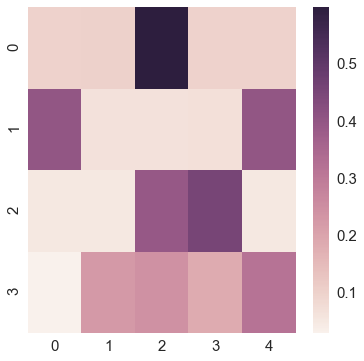

In [30]:
plot_heatmap(1,5)

In [31]:
# Manual testing
print(data.ix[0,'Narrative'])


The Peruvian Metro 23 was apparently involved in an accident as the wreck was seen in a hangar at Lima Airport on September 6, 2005. The aircraft was last seen active in July 2003.


In [33]:
# Get the words for each topic

all_topic_words = []
for topics in range(0,num_topics):
    topic_words = []
    words = lda.print_topics(num_topics=num_topics, num_words=10)[topics][1]
    words = words.split('+')
    for word in words:
        word = word.split('*')[1]
        word = word.replace('"','').rstrip()
        topic_words.append(word)
    all_topic_words.append(topic_words)

### Result: Top Words fo reach topic

In [34]:
for t in range(len(all_topic_words)):
    print("Topic {}: {}".format(t, ' '.join(all_topic_words[t][:15])))

Topic 0: accident damage destroyed transport international injured killed injuries pilot board
Topic 1: left right gear pilot nose wing engine first power rest
Topic 2: engine fire forced landed lost fuel caught failure ground dakota
Topic 3: weather conditions poor visibility altitude pilot mountain flew route area
Topic 4: hijacker demanded taken day hijackers hijacking reportedly hijacked less mountain


### Code below is to try and plot the words...

In [ ]:
num_top_words = 5

fontsize_base = 70 / np.max(60) # font size for word with largest share in corpus

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t))
#     top_words_idx = np.argsort(all_topic_words[:,t])[::-1]  # descending order
    top_words_idx = all_topic_words[:num_top_words]
    top_words = vocab[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base*share) 

plt.tight_layout()

## F. Summary

The topic modelling results are not very convincing. It requires more iterations before it can come up with meaningful distributions. Few of the options I am planning to try are:

- I think the stop words list needs to be expanded such that relevant words are picked by LDA model.
- I have seen that Topic extraction with Non-negative Matrix Factorization is an alternate method for LDA. I would like to try that and see its results too.
- SVM is supposedly a good way to check the accuracy of the LDA results. But the challenge is that the results cannot be compared to any training set. 
- If the topic results from modelling seem convincing enough, I will go ahead and use them. The idea is to add the extracted topics as a feature into the dataset. With this as a new feature, it would be an extra addition to analyzing the aviation accidents.